# Setup

## imports

In [1]:
import nibabel as nib
import numpy as np
import pandas as pd
from nilearn import image as nimg
from nilearn import plotting as nplot
from nilearn import masking as nimask
from matplotlib import pyplot as plt
import pickle
import os

## load in data

In [2]:
#LOADING IN
#one preprocessed scan
#nibable image

#abide_fmri_image_path = 'C:/Users/ahmm9/OneDrive - ITU/ITU/Research_proj/prepros_data/Outputs/ccs/filt_global/func_preproc'
#adhd200_fmri_image_path = 'C:/Users/ahmm9/OneDrive - ITU/ITU/Research_proj/Adhd200_preproc/NYU_preproc'
abide_fmri_image_path = '../DATA/pre_proc_ABIDE1/func_preproc'
adhd200_fmri_image_path = '../DATA/NYU_preproc'


#load in an example image
fmri_test_path = abide_fmri_image_path+"/NYU_0050970_func_preproc.nii"
fmri_test_path_adhd = adhd200_fmri_image_path+"/sfnwmrda0010001_session_1_rest_1.nii"
img = nib.load(fmri_test_path).get_fdata()

print(img.shape)
print(f"The .nii files are stored in memory as numpy's: {type(img)}.")

#load in parcellation mask
mask_path = 'data/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii'
img2 = nib.load(mask_path).get_fdata()
img2.shape


(61, 73, 61, 175)
The .nii files are stored in memory as numpy's: <class 'numpy.memmap'>.


(256, 256, 256, 1)

# EDA

## Plot data and mask

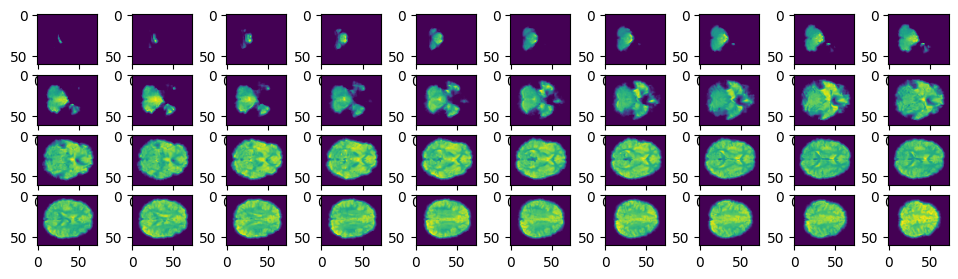

In [3]:
#frmi image
plt.style.use('default')
fig, axes = plt.subplots(4, 10, figsize=(12, 3))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img[:, :, i, 0])
plt.show()

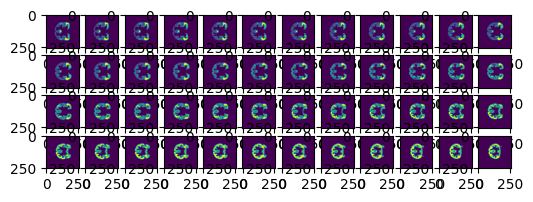

In [4]:
#Mask
plt.style.use('default')
fig, axes = plt.subplots(4, 12, figsize=(6, 2))
for i, ax in enumerate(axes.reshape(-1)):
    ax.imshow(img2[:, :, 125 + i, 0])  
    # Start from the 31st image (index 30)#TODO still this with different indexing??
plt.show()


## plot again?

In [5]:
#load with NILearn
abide_ni_image = nimg.load_img(fmri_test_path)
adhd200_ni_image = nimg.load_img(fmri_test_path_adhd)
ni_mask = nimg.load_img(mask_path)
print(abide_ni_image.shape)
print(adhd200_ni_image.shape)
print(ni_mask.shape)
print(ni_mask.affine)

(61, 73, 61, 175)
(49, 58, 47, 172)
(256, 256, 256, 1)
[[  -1.    0.    0.  127.]
 [   0.    0.    1. -145.]
 [   0.   -1.    0.  147.]
 [   0.    0.    0.    1.]]


In [6]:
print(abide_ni_image.affine)
print(adhd200_ni_image.affine)

[[  -3.   -0.   -0.   90.]
 [  -0.    3.   -0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
[[  -4.   -0.   -0.   96.]
 [  -0.    4.   -0. -132.]
 [   0.    0.    4.  -70.]
 [   0.    0.    0.    1.]]


In [7]:
print(abide_ni_image.slicer[:,:,:,5].get_fdata().shape)
print(abide_ni_image.slicer[:,:,:,5].get_fdata()[30:40, 30:40, 30])

print(adhd200_ni_image.slicer[:, :, :, 5].get_fdata().shape)
print(adhd200_ni_image.slicer[:, :, :, 5].get_fdata()[30:40, 30:40, 30])

(61, 73, 61)
[[ 9811.43945312 10097.35546875 10958.30371094 11560.92578125
  11672.24121094 11102.453125    9737.27050781  8766.56738281
  10013.00683594 11268.17773438]
 [10105.62207031 10725.42578125 11403.30957031 12275.43066406
  12242.43066406 12802.26269531 12641.40039062 10282.44433594
   8997.33203125  9750.62792969]
 [10276.03027344 11277.99316406 11954.30078125 12492.17089844
  12785.25976562 12648.55371094 13874.41601562 12480.94238281
   9403.14550781  8297.0859375 ]
 [10764.67871094 12130.37304688 12692.64550781 12734.65332031
  12817.96191406 12494.09472656 12599.54785156 13030.53125
   9758.62402344  8166.56298828]
 [12156.88671875 13874.81347656 14129.14160156 13268.98632812
  12755.27246094 11583.39355469 10728.71875     9884.04296875
   9391.34765625 10029.09960938]
 [14176.82910156 14644.71386719 14078.27929688 13040.88378906
  12226.53417969 11302.54199219 10658.92578125 10528.26269531
  11305.79101562 11818.70898438]
 [14939.33203125 14409.2421875  13412.44726562 1

In [8]:
adhd200_ni_image.slicer[:, :, :, 5].get_fdata()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

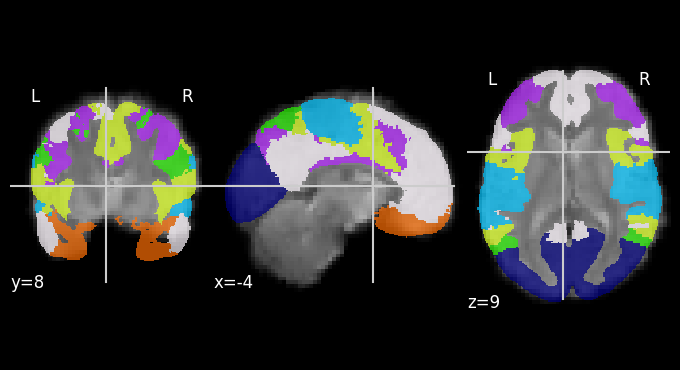

In [9]:
#show mask
nplot.plot_roi(ni_mask, abide_ni_image.slicer[:,:,:,30])


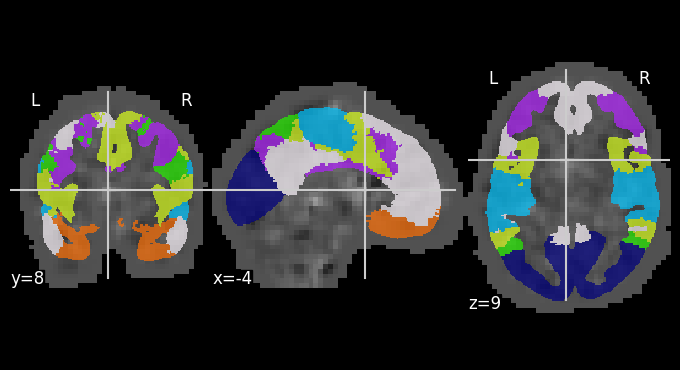

In [10]:
#show mask
nplot.plot_roi(ni_mask, adhd200_ni_image.slicer[:,:,:,30])


# Reshape Mask

## reshape mask to match images

In [11]:
#nilearn reshape dims of mask to match
abide_reshaped_mask = nimg.resample_img(ni_mask,target_affine=abide_ni_image.affine, interpolation='nearest',target_shape=abide_ni_image.shape[:3])
adhd200_reshaped_mask = nimg.resample_img(ni_mask,target_affine=adhd200_ni_image.affine, interpolation='nearest',target_shape=adhd200_ni_image.shape[:3])
print(abide_reshaped_mask.shape)
print(adhd200_reshaped_mask.shape)

(61, 73, 61, 1)
(49, 58, 47, 1)


## ADHD 200 preprocessing adjustment
The adhd200 preprocessing means that the values at edges of the scans are very close to 0, the values have also been normalised, so there are some values around 0 that are actual scan values. We set a small threshold around 0 such that values in this interval are removed, we aim to minimise the size of this interval, such that voxels values that are real, are considered to be part of the data

0.35001473701426444
0.1977820508542137


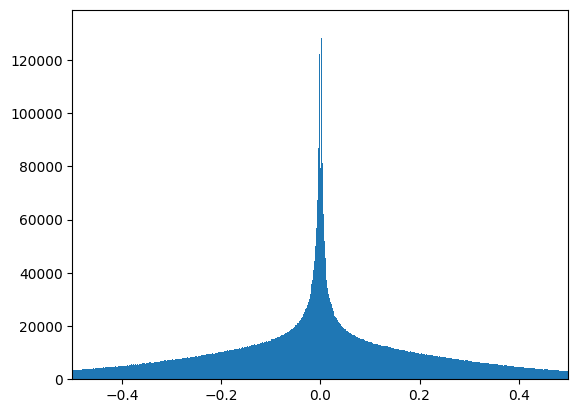

In [12]:
image_data = adhd200_ni_image.get_fdata()
thresh_ = 0.001
between_thresh = [i>thresh_ or i < -thresh_ for i in image_data.flatten()]
plt.hist(image_data.flatten()[between_thresh],bins = 10000);
plt.xlim(-0.5,0.5);
print(np.std(image_data.flatten()[between_thresh]))
print(np.std(image_data.flatten()))

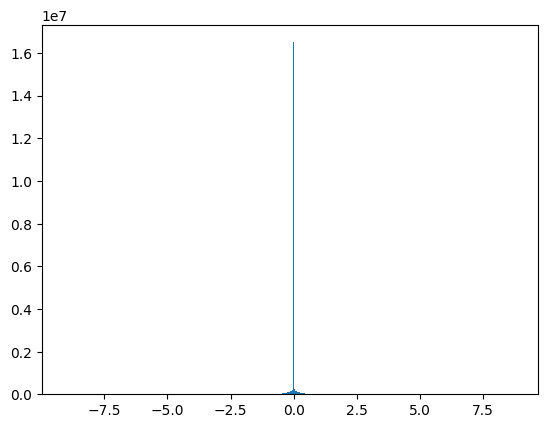

In [13]:
plt.hist(image_data.flatten(),bins = 1000);


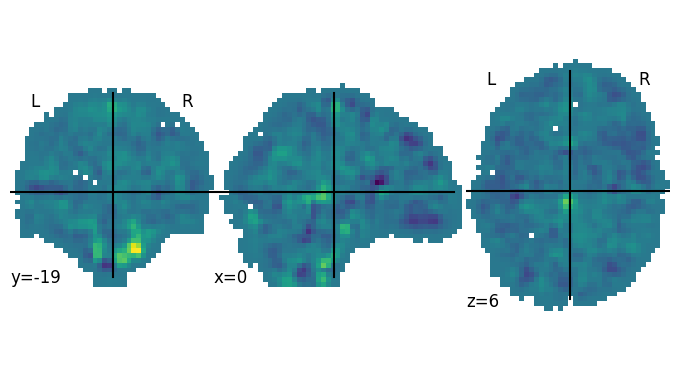

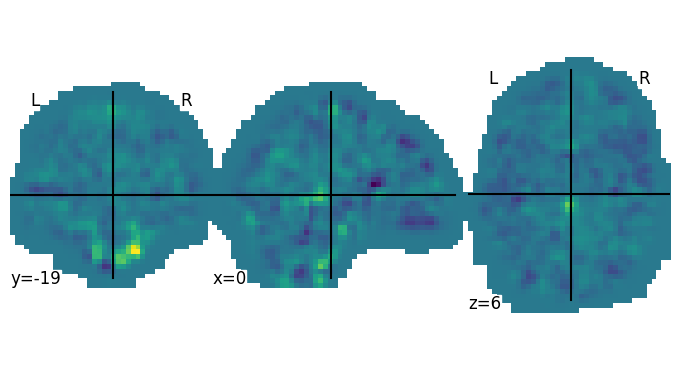

In [14]:
nplot.plot_img(adhd200_ni_image.slicer[:,:,:,20],threshold=0.001)
nplot.plot_img(adhd200_ni_image.slicer[:,:,:,20],threshold=0.0)

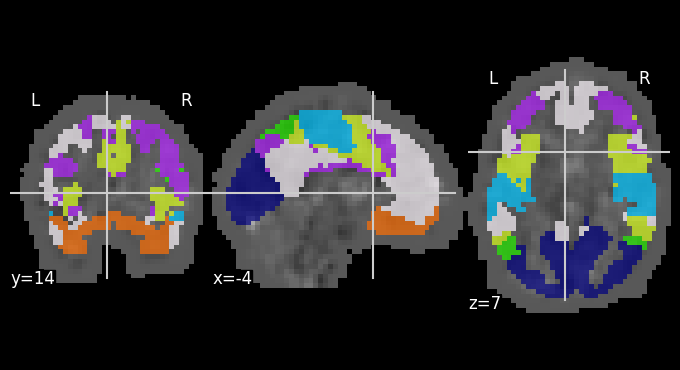

In [15]:
#plot the mask onto one slice of the frmi image
nplot.plot_roi(adhd200_reshaped_mask, adhd200_ni_image.slicer[:,:,:,5])

# other

In [16]:
#creates a mask dictionary with separate the regions as keys and the region masks as values
def create_parcellation_masks(nifti_mask, nifti_image):
    data = nifti_mask.get_fdata().astype(int)
    # Create a dictionary to store each mask
    masks = {}
    for value in range(1, 8):
        masks[value] = nib.Nifti1Image((data == value).astype(float), nifti_image.affine) # Create a mask for each unique value
    return masks

abide_mask_dict = create_parcellation_masks(abide_reshaped_mask,abide_ni_image)
adhd200_mask_dict = create_parcellation_masks(adhd200_reshaped_mask,adhd200_ni_image)

print(abide_mask_dict[1].shape)
print(adhd200_mask_dict[1].shape)

(61, 73, 61, 1)
(49, 58, 47, 1)


In [17]:
mask_reasonable_shape = abide_mask_dict[1].get_fdata().astype(int)[:,:,:,0]
not_brain = (mask_reasonable_shape == 0).sum()
brain = (mask_reasonable_shape != 0).sum()
print(brain,not_brain) # not brain is relative to parcellation
print("percentage of brain masked",(brain/(brain+not_brain))*100,"%")

mask_reasonable_shape = adhd200_mask_dict[1].get_fdata().astype(int)[:,:,:,0]
not_brain = (mask_reasonable_shape == 0).sum()
brain = (mask_reasonable_shape != 0).sum() ##TODO not accurate
print(brain,not_brain) # not brain is relative to parcellation
print("percentage of brain masked",(brain/(brain+not_brain))*100,"%")

6582 265051
percentage of brain masked 2.423122374674653 %
2772 130802
percentage of brain masked 2.075254166229955 %


In [18]:
#applies mask to image
def apply_mask(image,mask):
    output_dict = {}
    for i in range(1,8):
        stack = []
        masked = nimask.apply_mask(image, mask[i])
        row_check = masked[0][masked[0] != 0]
        for row in masked:
            masked_no_zeros = row[row != 0]
            # print(len(row_check))
            # print(len(masked_no_zeros))
            while len(masked_no_zeros) != len(row_check):
                mean_value = np.mean(row)
                print(masked_no_zeros.shape)
                masked_no_zeros = np.concatenate((masked_no_zeros,mean_value),axis=None)
            stack.append(masked_no_zeros)
        output_dict[i] = np.array(stack)
    return output_dict    

In [19]:
def compute_voxel_count_per_region(onescan_data):
    voxel_count = []
    for region in range(len(onescan_data.keys())):
        voxel_count.append(onescan_data[region+1].shape[1])
    return voxel_count


In [20]:
#get all images into list
all_images = []

#seg = pd.read_csv("ABIDE_phenotypic_NYU.csv")
labels = []

for phenotypic in os.listdir("data/selected_participants"):
    seg = pd.read_csv("data/selected_participants/"+phenotypic)
    print(phenotypic)
    if phenotypic.startswith("ABIDE_"):
        image_path = abide_fmri_image_path
        id_name = "SUB_ID"
        dx_name = "DX_GROUP"
        index_1 = 4
        index_2 = 11
        label_offset = 0
    else:
        image_path = adhd200_fmri_image_path
        id_name = "ScanDir ID"
        dx_name = "DX"
        index_1 = 8
        index_2 = 15
        label_offset = 10
    for filename in os.listdir(image_path):
        if filename.endswith('.nii') or filename.endswith('.nii.gz'):
            file_path = os.path.join(image_path, filename)
            sub_id = int(filename[index_1:index_2])
            dx_group = seg[seg[id_name] == sub_id][dx_name]
            if not dx_group.empty:
                labels.append(label_offset+int(dx_group.iloc[0]))
                img = nimg.load_img(file_path)
                # if (img.affine != affine_ref).any():
                #     img = resample_img(img, affine_ref, interpolation='linear')
                all_images.append(img)
print(np.array(all_images).shape)
print(np.array(labels).shape)
print(np.array(labels))


ABIDE_ASD_ADHD_Comorbid_phenotypic_NYU.csv
ABIDE_pure_ASD_phenotypic_NYU.csv
ABIDE_TD_phenotypic_NYU.csv
ADHD200_pure_ADHD_phenotypic_NYU.csv
ADHD200_TD_phenotypic_NYU.csv
(273,)
(273,)
[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2 13 13 12 13 13 11 11 11 11 13 13 11 11 11 11
 11 11 11 11 11 11 13 13 13 13 11 13 13 11 11 12 11 11 11 11 11 11 11 11
 11 11 11 13 13 13 11 13 13 11 11 11 11 11 11 11 11 13 13 11 13 13 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 13 11 11 11 11 11 11 11 11 13 13 13
 13 13 11 11 11 11 11 11 11 13 13 11 11 11 11 11 11 11 11 11 11 11 11 11
 11 11 11 11 11 11 11 11 11 11 11 11 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10
 10 10 10 1

In [21]:
#check affine is same for all images
print(len(all_images))
prev_img = all_images[0]
for img in all_images:
    if (prev_img.affine != img.affine).any():
        print("different")
    prev_img = img
    
print(all_images[0].affine)
print(all_images[270].affine)

273
different
[[  -3.   -0.   -0.   90.]
 [  -0.    3.   -0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
[[  -4.   -0.   -0.   96.]
 [  -0.    4.   -0. -132.]
 [   0.    0.    4.  -70.]
 [   0.    0.    0.    1.]]


In [22]:
affine_ref = [[  -3.,   -0.,   -0.,   90.],
 [  -0. ,   3. ,  -0., -126.],
 [   0.,    0.,    3.,  -72.],
 [   0.,    0. ,   0.,    1.]]

all_masked_images = []
start_index = 0
# running mask apply, save every 10th iteration, can be restarted and interrupted
try:
    with open('masked_image.pkl', 'rb') as f:
        print(f)
        all_masked_images = pickle.load(f)
        start_index = len(all_masked_images)
        print(f"Resuming from index {start_index}")
except FileNotFoundError:
    print("No previous save found, starting from scratch")
    
for i in range(start_index,len(all_images)):
    if (all_images[i].affine == affine_ref).all():
        all_masked_images.append(apply_mask(all_images[i],abide_mask_dict))
    else:
        all_masked_images.append(apply_mask(all_images[i],adhd200_mask_dict))
    if (i % 10 == 0):
        with open('masked_image.pkl', 'wb') as f:
            pickle.dump(all_masked_images,f)
        print("saved at index", i)

print("Applied mask to all images")
print(len(all_images) == len(all_masked_images))
print(all_images[0].shape[3] == len(all_masked_images[0][1]))

No previous save found, starting from scratch
saved at index 0
saved at index 10
saved at index 20
saved at index 30
saved at index 40
saved at index 50
saved at index 60
saved at index 70
saved at index 80
saved at index 90
(1446,)
saved at index 100
saved at index 110
saved at index 120
saved at index 130
saved at index 140
saved at index 150
saved at index 160
saved at index 170
(1724,)
saved at index 180
saved at index 190
saved at index 200
saved at index 210
saved at index 220
saved at index 230
(3757,)
saved at index 240
saved at index 250
saved at index 260
saved at index 270
Applied mask to all images
True
True


In [23]:
def threshold_per_participant(data):
    """each participant, whole timeframe"""
    thresholds = np.zeros((len(data),7))
    for i in range(len(data)): #each participant
        voxel_sum = np.empty(7)
        voxel_count = [abc * data[i][1].shape[0] for abc in compute_voxel_count_per_region(data[i])]
        for k in range(len(data[i].keys())): #region
            voxel_sum[k] = np.sum(data[i][k+1])
        means = voxel_sum/voxel_count
        thresholds[i] = means
    return thresholds

In [24]:
threshold_participant = threshold_per_participant(all_masked_images)
print("participant (participants,thresholds): ", threshold_participant.shape)
GTP_SHAPE = threshold_participant[0].shape

participant (participants,thresholds):  (273, 7)


In [25]:
## New version
def binarise(data,thresholds):
    bin_by_group = {1:[],2:[],10:[],11:[],12:[],13:[]}

    for scan_num,one_scan in enumerate(data):# for each participant
        image_label = labels[scan_num]
        # Binarize for single participant
        one_participant_bin = np.array(pd.DataFrame.from_dict(apply_threshold(one_scan,thresholds[scan_num]),orient="index"))
        bin_by_group[image_label].append(one_participant_bin)

    for group in bin_by_group:
        if (len(bin_by_group[group]) > 0):
            bin_by_group[group] = np.concatenate(bin_by_group[group],axis=1,dtype=int)
    return bin_by_group

def apply_threshold(participant, thresholds):
    binarized_participant = dict()
    if thresholds.shape == GTP_SHAPE:
        for k in participant.keys():            
            mean_image = (np.mean(participant[k], axis = 1)) - thresholds[k-1]
            binarized_participant[k] = np.where(mean_image > 0, 1, -1)
    else:
        raise ValueError("thresholds does have correct dimensions, found dimension:", thresholds.shape )
    return binarized_participant

In [26]:
binarized = binarise(all_masked_images,threshold_participant)
binarized[1].shape

(7, 3675)

In [27]:
#save
for i in binarized.keys():
    np.savetxt(f"data/reader_output_matlab_input/Binarized_Data_Group_{i}",binarized[i],fmt="%d",delimiter=",")